### **O problema**

Você foi recentemente alocado em uma equipe de cientistas de dados de
um grande fundo de investimentos brasileiro. **Sua missão inicial é desenvolver
um modelo preditivo capaz de prever se o índice IBOVESPA vai fechar em alta
ou baixa no dia seguinte, com base em dados históricos do próprio índice.** Esse
modelo será usado como insumo para alimentar dashboards internos de tomada
de decisão dos analistas quantitativos da empresa.

### **Dados**
Utilize os dados históricos do índice IBOVESPA, disponíveis
publicamente: https://br.investing.com/indices/bovespa-historical-data

**Requisitos:**

*  Selecione o período “diário”
*  Baixe um intervalo de pelo menos 2 anos de dados.
*  Realize o pré-processamento necessário para utilizar os dados no
modelo.

### **Objetivo**
Criar um modelo que preveja se o fechamento do IBOVESPA do dia
seguinte será maior ou menor que o do dia atual.

### **Observações**
Seu modelo deve prever a tendência (↑ ou ↓) com **acuracidade mínima
de 75%** em um conjunto de teste. O conjunto de testes deverá conter o último
mês (30 dias) de dados disponíveis.





---



### Analise exploratoria

In [1636]:
#Importação das principais bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1637]:
df = pd.read_csv('/content/Dados Históricos - Ibovespa.csv')
print(df.shape)
df.head(5)

(499, 7)


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,04.06.2025,137.002,137.547,138.797,136.695,"10,20B","-0,40%"
1,03.06.2025,137.546,136.787,137.672,136.175,"9,70B","0,56%"
2,02.06.2025,136.787,137.026,138.471,136.483,"9,10B","-0,18%"
3,30.05.2025,137.027,138.546,138.637,136.726,"15,14B","-1,09%"
4,29.05.2025,138.534,138.869,139.108,137.993,"8,83B","-0,25%"


In [1638]:
df.describe()

,Último,Abertura,Máxima,Mínima
count,499.000000,499.000000,499.000000,499.000000
mean,125.958741,125.910299,126.733513,125.176974
std,6.206161,6.215017,6.175534,6.217346
min,112.532000,112.534000,113.071000,111.599000
25%,120.767000,120.763500,121.736000,120.155000
50%,126.922000,126.923000,127.657000,126.065000
75%,130.111000,130.051000,130.783500,129.348500
max,140.110000,140.109000,140.382000,138.966000


In [1639]:
#Ajuste dos cabeçalhos das colunas
df.rename(columns={'Data':'data','Último':'ultimo','Abertura':'abertura','Máxima':'maxima','Mínima':'minima','Vol.':'vol','Var%':'var'}, inplace = True)

In [1640]:
df.dtypes

,0
data,object
ultimo,float64
abertura,float64
maxima,float64
minima,float64
vol,object
var,object


Ao observar os tipos das colunas, podemos notar que será necessario alterar as colunas "data" para formate date, enquanto que as coluna "vol" e "var" para o formato float.

In [1641]:
#Analise da coluna de vol
df['vol'].str[-1].unique().tolist()

['B', 'M']

Ao extrair os ultimos caracteres e transforma-los numa lista unica, podemos que que temos apenas as unidade de Bilhão e Milhão.

In [1642]:
#Ajuste da coluna "vol"
def ajusteVol(valor):
    if valor[-1] == 'M':
        return float(valor[:-1].replace(',', '.')) * 1_000_000
    elif valor[-1] == 'B':
        return float(valor[:-1].replace(',', '.')) * 1_000_000_000
    else:
        return float(valor.replace(',', '.'))

# Aplicar à coluna
df['vol'] = df['vol'].apply(ajusteVol)

In [1643]:
#Ajuste das coluna "data" e "var"
df['data'] = pd.to_datetime(df['data'], format='%d.%m.%Y')
df['var'] = (df['var'].str.replace('%', '').str.replace(',', '.').astype(float))

print(df.dtypes)

data        datetime64[ns]
ultimo             float64
abertura           float64
maxima             float64
minima             float64
vol                float64
var                float64
dtype: object


In [1644]:
df.describe()

,data,ultimo,abertura,maxima,minima,vol,var
count,499,499.000000,499.000000,499.000000,499.000000,4.990000e+02,499.000000
mean,2024-06-02 09:54:28.136272640,125.958741,125.910299,126.733513,125.176974,2.233692e+09,0.043567
min,2023-06-05 00:00:00,112.532000,112.534000,113.071000,111.599000,4.330000e+06,-3.150000
25%,2023-12-02 12:00:00,120.767000,120.763500,121.736000,120.155000,8.940000e+06,-0.505000
50%,2024-06-05 00:00:00,126.922000,126.923000,127.657000,126.065000,1.057000e+07,0.030000
75%,2024-11-28 12:00:00,130.111000,130.051000,130.783500,129.348500,1.507000e+07,0.620000
max,2025-06-04 00:00:00,140.110000,140.109000,140.382000,138.966000,2.487000e+10,3.120000
std,NaN,6.206161,6.215017,6.175534,6.217346,4.535854e+09,0.911987


In [1645]:
df.isnull().sum()

,0
data,0
ultimo,0
abertura,0
maxima,0
minima,0
vol,0
var,0


Ao observar os valores nulos, é possivel notar que não há presença de dados nulos na base

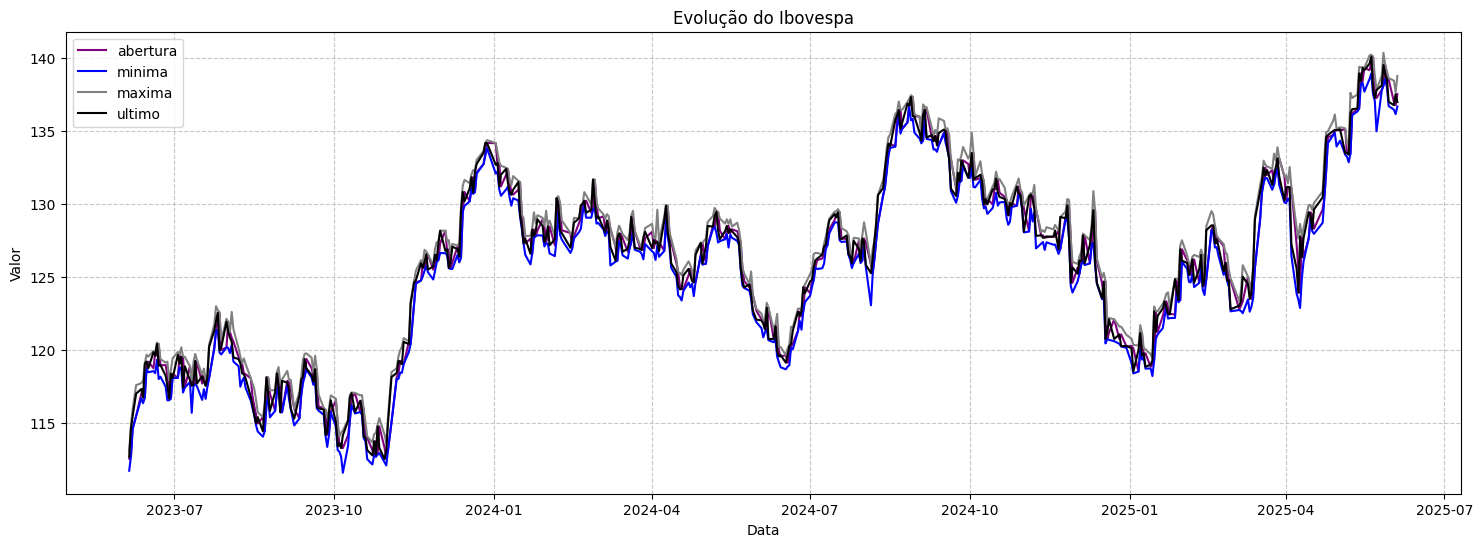

In [1646]:
#criando a figura
plt.figure(figsize = (18,6))

sns.lineplot(data = df,x = 'data', y = 'abertura',color = 'purple',label = 'abertura')
sns.lineplot(data = df,x='data',y='minima', color = 'blue', label = 'minima')
sns.lineplot(data = df,x='data',y='maxima', color = 'gray', label = 'maxima')
sns.lineplot(data = df,x='data',y='ultimo', color = 'black', label = 'ultimo')


plt.title('Evolução do Ibovespa')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.grid(linestyle ='--', alpha = 0.7)
plt.legend()

Ao observar o grafico, é possivel notar que os valores da ibovespa apresenta uma tendencia de crescimento por "queda", ou seja, ela vai subindo e caindo, porem com uma tendencia sempre maior que o ano anterior.

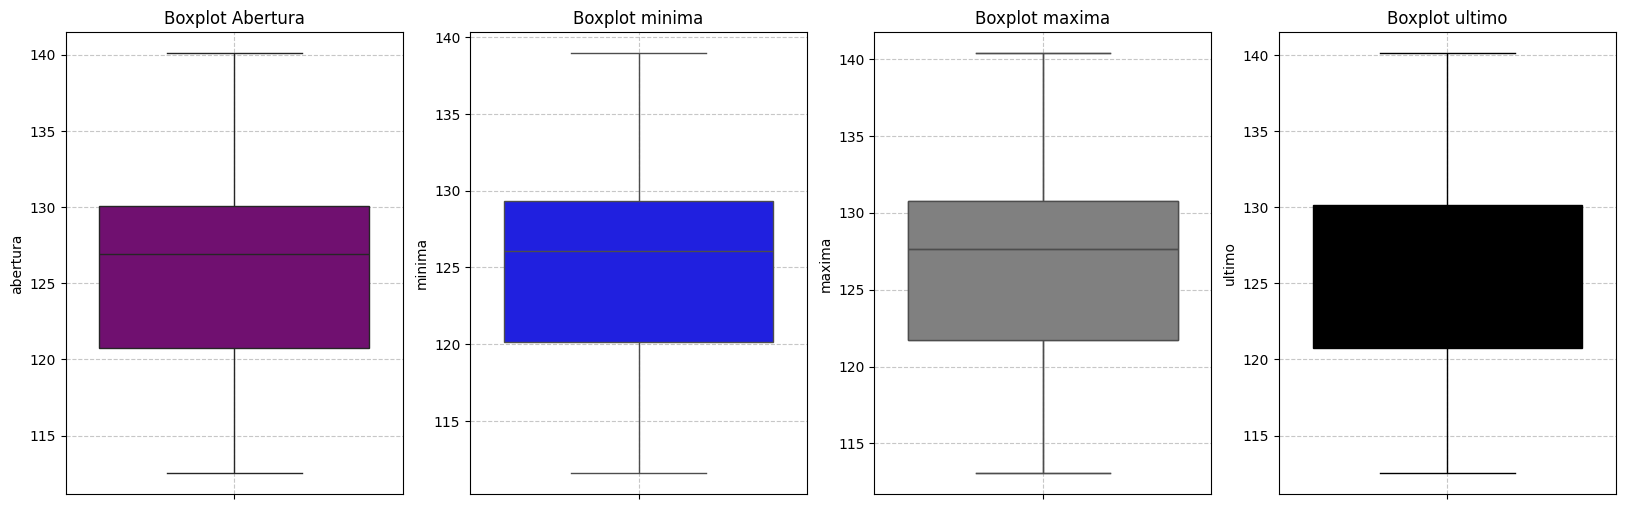

In [1647]:
#Criando a imagem
fig, axs = plt.subplots(1,4, figsize=(20, 6))

sns.boxplot(data = df, y = 'abertura',ax = axs[0], color = 'purple')
axs[0].set_title('Boxplot Abertura')
axs[0].grid(linestyle ='--', alpha = 0.7)

sns.boxplot(data = df, y = 'minima',ax = axs[1], color = 'blue')
axs[1].set_title('Boxplot minima')
axs[1].grid(linestyle ='--', alpha = 0.7)

sns.boxplot(data = df, y = 'maxima',ax = axs[2], color = 'gray')
axs[2].set_title('Boxplot maxima')
axs[2].grid(linestyle ='--', alpha = 0.7)

sns.boxplot(data = df, y = 'maxima',ax = axs[2], color = 'gray')
axs[2].set_title('Boxplot maxima')
axs[2].grid(linestyle ='--', alpha = 0.7)

sns.boxplot(data = df, y = 'ultimo',ax = axs[3], color = 'black')
axs[3].set_title('Boxplot ultimo')
axs[3].grid(linestyle ='--', alpha = 0.7)

Ao observar os boxplots, é possivel notar que não há a presença de outliers para as informações de valores de abertura, minimo e maximo do ibovespa

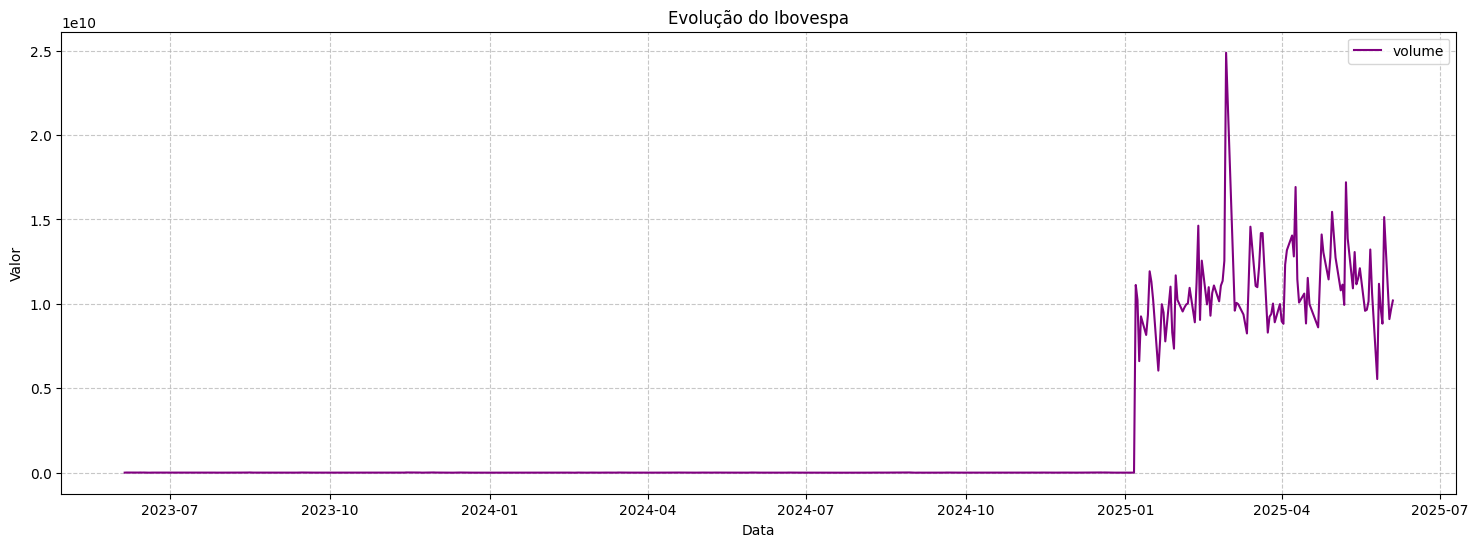

In [1648]:
#criando a figura
plt.figure(figsize = (18,6))

sns.lineplot(data = df,x = 'data', y = 'vol',color = 'purple',label = 'volume')

plt.title('Evolução do Ibovespa')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.grid(linestyle ='--', alpha = 0.7)
plt.legend()

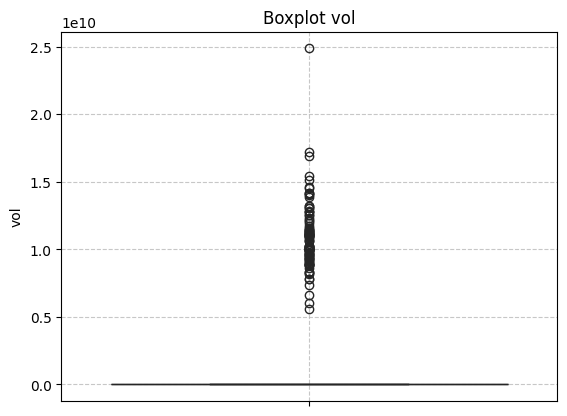

In [1649]:
#Criando a imagem
figure = figsize=(20, 6)

sns.boxplot(data = df, y = 'vol', color = 'purple')
plt.title('Boxplot vol')
plt.grid(linestyle ='--', alpha = 0.7)

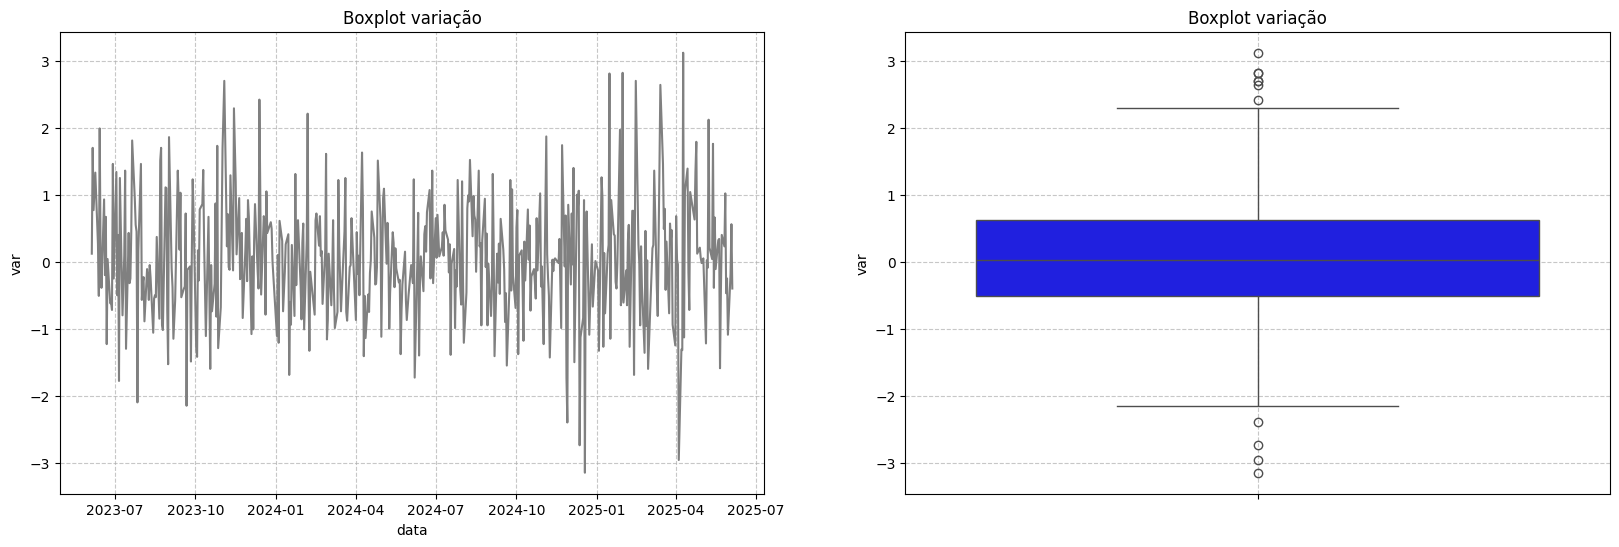

In [1650]:
#Criando a imagem
fig, axs = plt.subplots(1,2, figsize=(20, 6))

sns.lineplot(data = df,x='data',y='var',ax = axs[0], color = 'gray')
axs[0].set_title('Boxplot variação')
axs[0].grid(linestyle ='--', alpha = 0.7)


sns.boxplot(data = df, y = 'var',ax = axs[1], color = 'blue')
axs[1].set_title('Boxplot variação')
axs[1].grid(linestyle ='--', alpha = 0.7)

Ao observar as informações de variação, é possivel notar a presença de outliers

## XGBoosting

In [1651]:
import xgboost as xgb
from xgboost import XGBRegressor
import datetime as dt

In [1652]:
dfXgboost = pd.read_csv('/content/Dados Históricos - Ibovespa.csv')
dfXgboost.head(5)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,04.06.2025,137.002,137.547,138.797,136.695,"10,20B","-0,40%"
1,03.06.2025,137.546,136.787,137.672,136.175,"9,70B","0,56%"
2,02.06.2025,136.787,137.026,138.471,136.483,"9,10B","-0,18%"
3,30.05.2025,137.027,138.546,138.637,136.726,"15,14B","-1,09%"
4,29.05.2025,138.534,138.869,139.108,137.993,"8,83B","-0,25%"


In [1653]:
dfXgboost = dfXgboost[['Data','Último','Abertura','Máxima','Mínima']]
dfXgboost = dfXgboost.rename(columns={'Data':'data','Último':'fechamento','Abertura':'abertura','Máxima':'maxima','Mínima':'minima'})
dfXgboost.head(5)

#Ajustando o formato de data para a coluna de Data
dfXgboost['data'] = pd.to_datetime(dfXgboost['data'], format='%d.%m.%Y')
dfXgboost = dfXgboost.set_index('data')
dfXgboost.head(5)

,fechamento,abertura,maxima,minima
data,,,,
2025-06-04,137.002,137.547,138.797,136.695
2025-06-03,137.546,136.787,137.672,136.175
2025-06-02,136.787,137.026,138.471,136.483
2025-05-30,137.027,138.546,138.637,136.726
2025-05-29,138.534,138.869,139.108,137.993


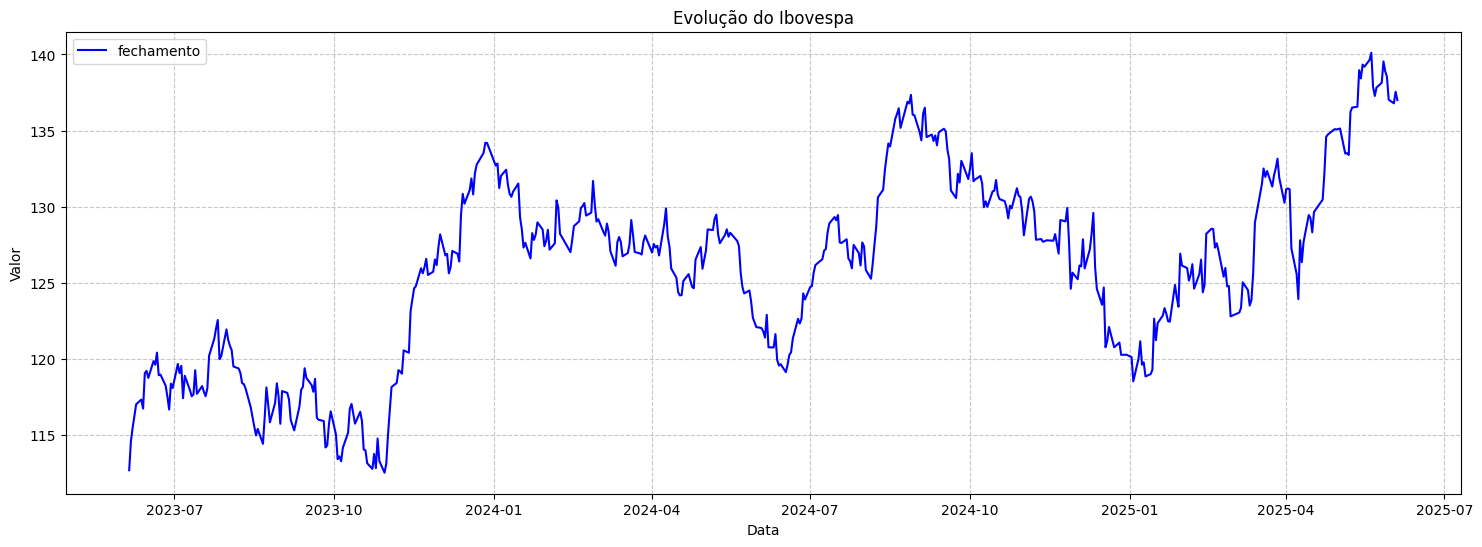

In [1654]:
#criando a figura
plt.figure(figsize = (18,6))

sns.lineplot(data = dfXgboost,x = 'data', y = 'fechamento',color = 'blue',label = 'fechamento')
plt.title('Evolução do Ibovespa')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.grid(linestyle ='--', alpha = 0.7)
plt.legend()

### Criação das features

In [1655]:
# Adição das variveis de temporais

dfXgboost["diadasemana"] = dfXgboost.index.dayofweek
dfXgboost["diadomes"] = dfXgboost.index.day
dfXgboost["mes"] = dfXgboost.index.month
dfXgboost["semanadoano"] = dfXgboost.index.isocalendar().week
dfXgboost["ano"] = dfXgboost.index.year

dfXgboost.head(5)

,fechamento,abertura,maxima,minima,diadasemana,diadomes,mes,semanadoano,ano
data,,,,,,,,,
2025-06-04,137.002,137.547,138.797,136.695,2,4,6,23,2025
2025-06-03,137.546,136.787,137.672,136.175,1,3,6,23,2025
2025-06-02,136.787,137.026,138.471,136.483,0,2,6,23,2025
2025-05-30,137.027,138.546,138.637,136.726,4,30,5,22,2025
2025-05-29,138.534,138.869,139.108,137.993,3,29,5,22,2025


In [1656]:
# Deslocamento os valores do fechamento, abertura, maxima e minina
dfXgboost['fechamento_1'] = dfXgboost['fechamento'].shift(1)
dfXgboost['fechamento_7'] = dfXgboost['fechamento'].shift(7)
dfXgboost['fechamento_30'] = dfXgboost['fechamento'].shift(30)

dfXgboost['mediaFechamento_7'] = dfXgboost['fechamento'].shift(1).rolling(7).mean()
dfXgboost['mediaFechamento_15'] = dfXgboost['fechamento'].shift(1).rolling(15).mean()
dfXgboost['mediaFechamento_30'] = dfXgboost['fechamento'].shift(1).rolling(30).mean()

dfXgboost['abertura_1'] = dfXgboost['abertura'].shift(1)
dfXgboost['abertura_7'] = dfXgboost['abertura'].shift(7)
dfXgboost['abertura_30'] = dfXgboost['abertura'].shift(30)

dfXgboost['maxima_1'] = dfXgboost['maxima'].shift(1)
dfXgboost['maxima_7'] = dfXgboost['maxima'].shift(7)
dfXgboost['maxima_30'] = dfXgboost['maxima'].shift(30)

dfXgboost['minima_1'] = dfXgboost['minima'].shift(1)
dfXgboost['minima_7'] = dfXgboost['minima'].shift(7)
dfXgboost['minima_30'] = dfXgboost['minima'].shift(30)

# dfXgboost['MediaMinimaMaxima_1'] = (dfXgboost['minima_1']  + dfXgboost['maxima_1'])/2
# dfXgboost['MediaMinimaMaxima_7'] = (dfXgboost['minima_7']  + dfXgboost['maxima_7'])/2



#Remoção das linhas nulos do lag
dfXgboost = dfXgboost.dropna()

dfXgboost.head(5)

,fechamento,abertura,maxima,minima,diadasemana,diadomes,mes,semanadoano,ano,fechamento_1,...,mediaFechamento_30,abertura_1,abertura_7,abertura_30,maxima_1,maxima_7,maxima_30,minima_1,minima_7,minima_30
data,,,,,,,,,,,,,,,,,,,,,
2025-04-22,130.464,129.650,130.877,128.726,1,22,4,17,2025,132.216,...,136.788300,130.468,135.067,137.547,133.318,135.275,138.797,130.468,134.355,136.695
2025-04-17,129.650,128.316,130.091,127.973,3,17,4,16,2025,130.464,...,136.570367,129.650,135.094,136.787,130.877,135.171,137.672,128.726,133.955,136.175
2025-04-16,128.317,129.245,129.605,128.149,2,16,4,16,2025,129.650,...,136.307167,128.316,135.017,137.026,130.091,136.150,138.471,127.973,134.899,136.483
2025-04-15,129.245,129.452,129.927,128.951,1,15,4,16,2025,128.317,...,136.024833,129.245,134.741,138.546,129.605,135.709,138.637,128.149,134.711,136.726
2025-04-14,129.454,127.683,129.955,127.683,0,14,4,16,2025,129.245,...,135.765433,129.452,134.579,138.869,129.927,134.992,139.108,128.951,134.186,137.993


### Separação em treino/teste

In [1657]:
train_size = int(len(df)*0.80)
train_size

399

In [1658]:
#Ajustando a ordenação
dfXgboost = dfXgboost.sort_index(ascending=True)

#Separação em treino e teste
train = dfXgboost.iloc[:train_size]
test = dfXgboost.iloc[train_size:]

In [1659]:
dataCorte = dfXgboost.index[train_size]
dataCorte

Timestamp('2025-01-09 00:00:00')

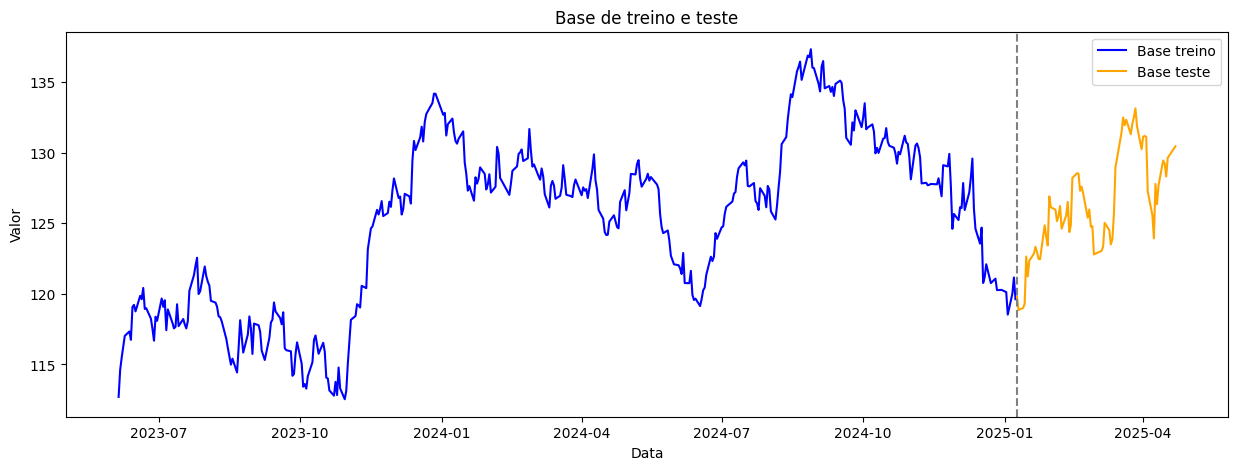

In [1660]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data = train,x = train.index, y = 'fechamento',color = 'blue',label = 'Base treino',ax=ax)
sns.lineplot(data = test,x = test.index, y = 'fechamento',color = 'orange',label = 'Base teste',ax=ax)
ax.axvline(pd.to_datetime('2025-01-09'), color='gray', ls='--')
ax.legend()
plt.title('Base de treino e teste')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.show()

In [1661]:
#Modelo
varTreino = ['diadasemana','diadomes','mes','semanadoano','ano',
             'fechamento_1','fechamento_7','fechamento_30',
              'abertura_1','abertura_7','abertura_30',
             'mediaFechamento_7','mediaFechamento_15','mediaFechamento_30',
             'maxima_1','maxima_7','maxima_30',
             'minima_1','minima_7','minima_30'
            #  'MediaMinimaMaxima_1','MediaMinimaMaxima_7'
             ]

X_train = train[varTreino]
y_train = train['fechamento']

X_test = test[varTreino]
y_test = test['fechamento']

In [1662]:
model = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=500,
                       early_stopping_rounds=50,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)

model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:123.46456	validation_1-rmse:124.73844
[100]	validation_0-rmse:45.48074	validation_1-rmse:45.96170
[200]	validation_0-rmse:16.80655	validation_1-rmse:16.93246
[300]	validation_0-rmse:6.23028	validation_1-rmse:6.29218
[400]	validation_0-rmse:2.31908	validation_1-rmse:2.35357
[499]	validation_0-rmse:0.87754	validation_1-rmse:0.92027


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

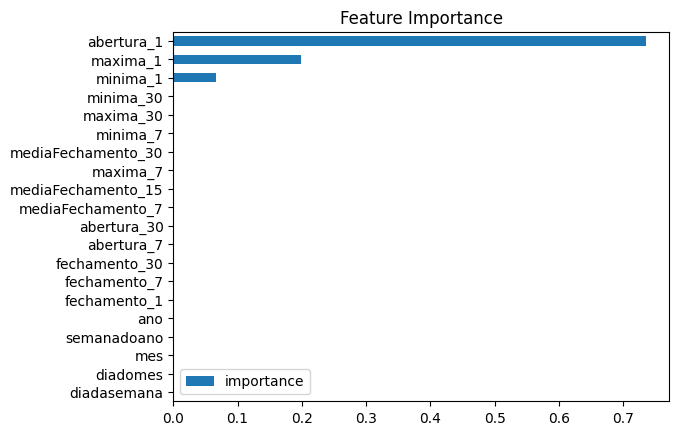

In [1663]:
fi = pd.DataFrame(data=model.feature_importances_,
             index=model.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [1664]:
test['prediction'] = model.predict(X_test)

/tmp/ipython-input-1664-3864373789.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = model.predict(X_test)


In [1665]:
dfXgboostfinal = dfXgboost.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [1666]:
dfXgboostfinal.tail(5)

,fechamento,abertura,maxima,minima,diadasemana,diadomes,mes,semanadoano,ano,fechamento_1,...,abertura_1,abertura_7,abertura_30,maxima_1,maxima_7,maxima_30,minima_1,minima_7,minima_30,prediction
data,,,,,,,,,,,,,,,,,,,,,
2025-04-14,129.454,127.683,129.955,127.683,0,14,4,16,2025,129.245,...,129.452,134.579,138.869,129.927,134.992,139.108,128.951,134.186,137.993,128.513489
2025-04-15,129.245,129.452,129.927,128.951,1,15,4,16,2025,128.317,...,129.245,134.741,138.546,129.605,135.709,138.637,128.149,134.711,136.726,128.345612
2025-04-16,128.317,129.245,129.605,128.149,2,16,4,16,2025,129.650,...,128.316,135.017,137.026,130.091,136.150,138.471,127.973,134.899,136.483,127.408028
2025-04-17,129.650,128.316,130.091,127.973,3,17,4,16,2025,130.464,...,129.650,135.094,136.787,130.877,135.171,137.672,128.726,133.955,136.175,128.716965
2025-04-22,130.464,129.650,130.877,128.726,1,22,4,17,2025,132.216,...,130.468,135.067,137.547,133.318,135.275,138.797,130.468,134.355,136.695,129.469147


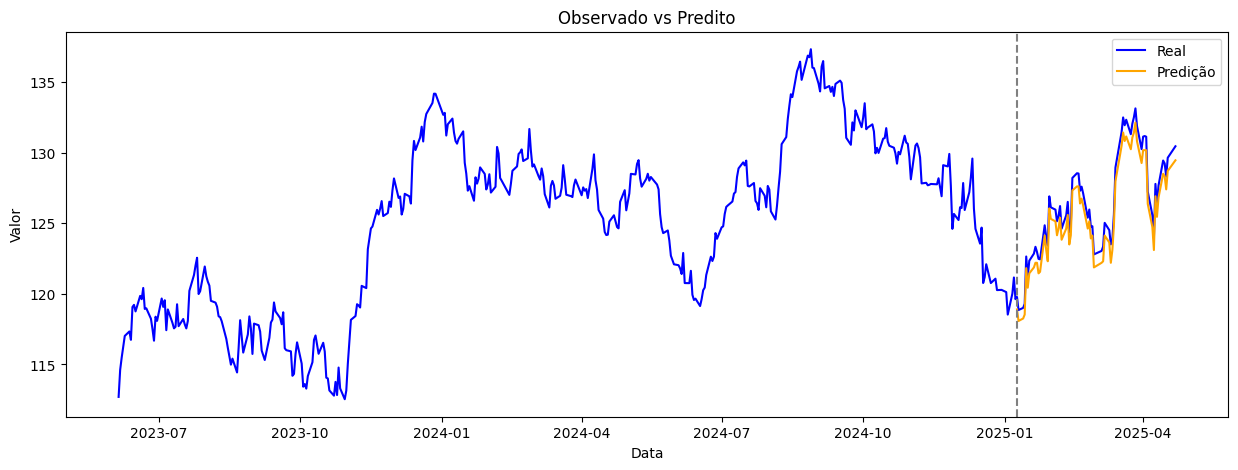

In [1667]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(data = dfXgboostfinal,x = dfXgboost.index, y = 'fechamento',color = 'blue',label = 'Real',ax=ax)
sns.lineplot(data = dfXgboostfinal,x = dfXgboost.index, y = 'prediction',color = 'Orange',label = 'Predição',ax=ax)
ax.axvline(pd.to_datetime('2025-01-09'), color='gray', ls='--')
ax.legend()
plt.title('Observado vs Predito')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.show()

### Avaliando a acuracia

In [1668]:
dfXgboostfinal.index.max()

Timestamp('2025-04-22 00:00:00')

In [1669]:
#Pegando os ultimos 30 dias
dfAcuracia = dfXgboostfinal.loc[dfXgboostfinal.index >= '2025-03-07']
dfAcuracia = dfAcuracia[['fechamento','prediction']]
len(dfAcuracia)

31

In [1670]:
def tendencia(x):
    if pd.isna(x):
        return '-'
    elif x > 0:
        return 'aumento'
    elif x < 0:
        return 'queda'
    else:
        return 'estabilidade'

In [1671]:
dfAcuracia['tendenciaOriginal'] = dfAcuracia['fechamento'].diff().apply(tendencia)
dfAcuracia['tendenciaPrevista'] = dfAcuracia['prediction'].diff().apply(tendencia)

dfAcuracia.head(5)

,fechamento,prediction,tendenciaOriginal,tendenciaPrevista
data,,,,
2025-03-07,125.035,124.136482,-,-
2025-03-10,124.519,123.645248,queda,queda
2025-03-11,123.507,122.203606,queda,queda
2025-03-12,123.864,123.106300,aumento,aumento
2025-03-13,125.637,124.830971,aumento,aumento


In [1672]:
dfAcuracia['Acuracia'] = dfAcuracia['tendenciaOriginal'] == dfAcuracia['tendenciaPrevista']
dfAcuracia.head(5)

,fechamento,prediction,tendenciaOriginal,tendenciaPrevista,Acuracia
data,,,,,
2025-03-07,125.035,124.136482,-,-,True
2025-03-10,124.519,123.645248,queda,queda,True
2025-03-11,123.507,122.203606,queda,queda,True
2025-03-12,123.864,123.106300,aumento,aumento,True
2025-03-13,125.637,124.830971,aumento,aumento,True


In [1673]:
#Qnt de acertos
acertos = dfAcuracia['Acuracia'].sum()

#Remoção da primeira linha
total = len(dfAcuracia['Acuracia']) - 1

#Calculando a acurácia
Acuracia = round(acertos / total * 100, 2)

# Imprimindo o resultado formatado
print(f"O modelo de XGBoost obteve uma acurácia de: {Acuracia:.2f}%")

O modelo de XGBoost obteve uma acurácia de: 96.67%


## Arima

In [1674]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf

In [1675]:
df = pd.read_csv('/content/Dados Históricos - Ibovespa.csv')
print(df.shape)
df.head(5)

(499, 7)


,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,04.06.2025,137.002,137.547,138.797,136.695,"10,20B","-0,40%"
1,03.06.2025,137.546,136.787,137.672,136.175,"9,70B","0,56%"
2,02.06.2025,136.787,137.026,138.471,136.483,"9,10B","-0,18%"
3,30.05.2025,137.027,138.546,138.637,136.726,"15,14B","-1,09%"
4,29.05.2025,138.534,138.869,139.108,137.993,"8,83B","-0,25%"


Para a aplicação do algoritmo de ARIMA, iremos apenas trabalhar com as coluna de Data e Abertura

In [1676]:
df.tail(5)

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
494,12.06.2023,117.336,117.022,117.735,116.704,"12,02M","0,27%"
495,09.06.2023,117.019,115.489,117.603,115.489,"13,53M","1,33%"
496,07.06.2023,115.488,114.610,115.978,114.610,"14,02M","0,77%"
497,06.06.2023,114.610,112.697,114.783,112.696,"15,03M","1,70%"
498,05.06.2023,112.696,112.558,113.071,111.736,"9,08M","0,12%"


In [1677]:
dfArima = df[['Data','Último']]
dfArima = dfArima.rename(columns={'Data':'data','Último':'fechamento'})

#Definindo a coluna data como indice
# dfArima = dfArima.set_index('Data')
# dfArima.head(5)

#Ajustando o formato de data para a coluna de Data
dfArima['data'] = pd.to_datetime(dfArima['data'], format='%d.%m.%Y')
dfArima = dfArima.set_index('data')
dfArima.head(5)

,fechamento
data,
2025-06-04,137.002
2025-06-03,137.546
2025-06-02,136.787
2025-05-30,137.027
2025-05-29,138.534


In [1678]:
dfArima.isnull().sum()

,0
fechamento,0


Ao observar a base, notamos que não há valores nulos

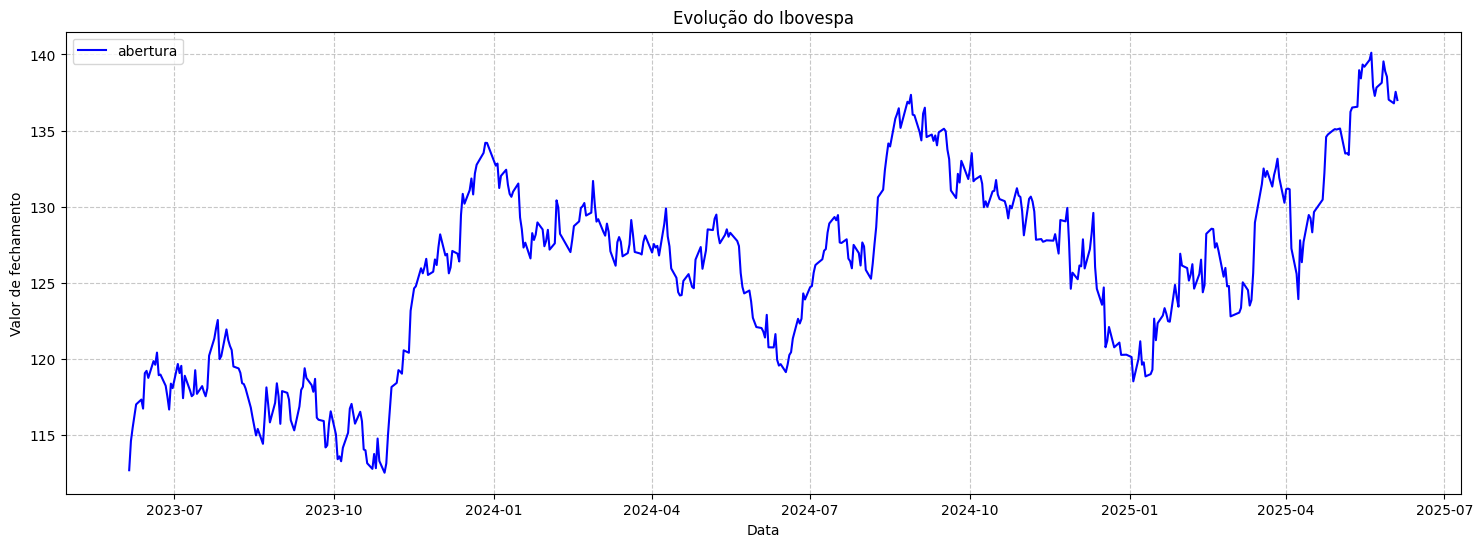

In [1679]:
plt.figure(figsize = (18,6))

sns.lineplot(data = dfArima,x = dfArima.index, y = 'fechamento',color = 'blue',label = 'abertura',markers='o')
# plt.plot(dfArima.index, dfArima['fechamento'], color='blue', label='Abertura')
plt.title('Evolução do Ibovespa')
plt.xlabel('Data')
plt.ylabel('Valor de fechamento')
plt.grid(linestyle ='--', alpha = 0.7)


Ao observar o valores de fechamento, é possivel observar uma certa tendencia de aumento com um comportamento de sazonalidade. Dessa forma, a tendencia de aumento indica que a serie não apresenta o comportamento de **serie não estacionaria**

### Teste de estacionariadade

In [1680]:
from statsmodels.tsa.stattools import adfuller

In [1681]:
X = dfArima.fechamento.values

In [1682]:
result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]:.2f}")
print(f"P-Value: {result[1]:.2f}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value:.2f}")

Teste ADF
Teste Estatístico: -1.89
P-Value: 0.34
Valores críticos:
	1%: -3.44
	5%: -2.87
	10%: -2.57


Pelo teste ADF, obtemos um valor de p-value igual a 0,34. Dessa forma, temos um valor maior que 0,05, a nossa **serie não é estacionaria**. Confirmando as a hipotese levantanda pelos graficos anteriores.

### Decomposição da serie

In [1683]:
#Ajuste da frequencia do indice
print(dfArima.index.freq)

None


O pandas não reconheceu o nosso indice configurado automaticamente

In [1684]:
# Ajuste para a frequencia de dias uteis
dfArima = dfArima.asfreq('B')
dfArima

,fechamento
data,
2023-06-05,112.696
2023-06-06,114.610
2023-06-07,115.488
2023-06-08,NaN
2023-06-09,117.019
...,...
2025-05-29,138.534
2025-05-30,137.027
2025-06-02,136.787


In [1685]:
dfArima.isnull().sum()

,0
fechamento,24


Ao ajustar o formato para dias uteis, é notado que ocorre a incorpação de linhas vazias, por conta dos feriados.

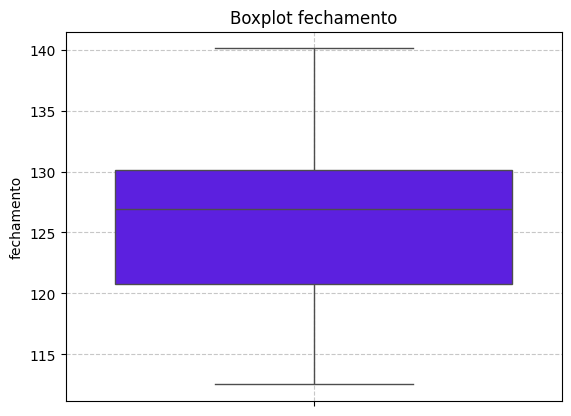

In [1686]:
#Criando a imagem
figure = figsize=(20, 6)

sns.boxplot(data = dfArima, y = 'fechamento', color = '#5000ff')
plt.title('Boxplot fechamento')
plt.grid(linestyle ='--', alpha = 0.7)

In [1687]:
print("Média: ",dfArima['fechamento'].mean())
print("Medina: ",dfArima['fechamento'].median())

Média:  125.95874148296593
Medina:  126.922


Visto que não há valores de outliers, a média e a mediana ficam muito proximas. Dessa forma, iremos preencher os valores nulos com a média

In [1688]:
media = dfArima['fechamento'].mean()
dfArima = dfArima['fechamento'].fillna(media)

print(dfArima.isnull().sum())

0


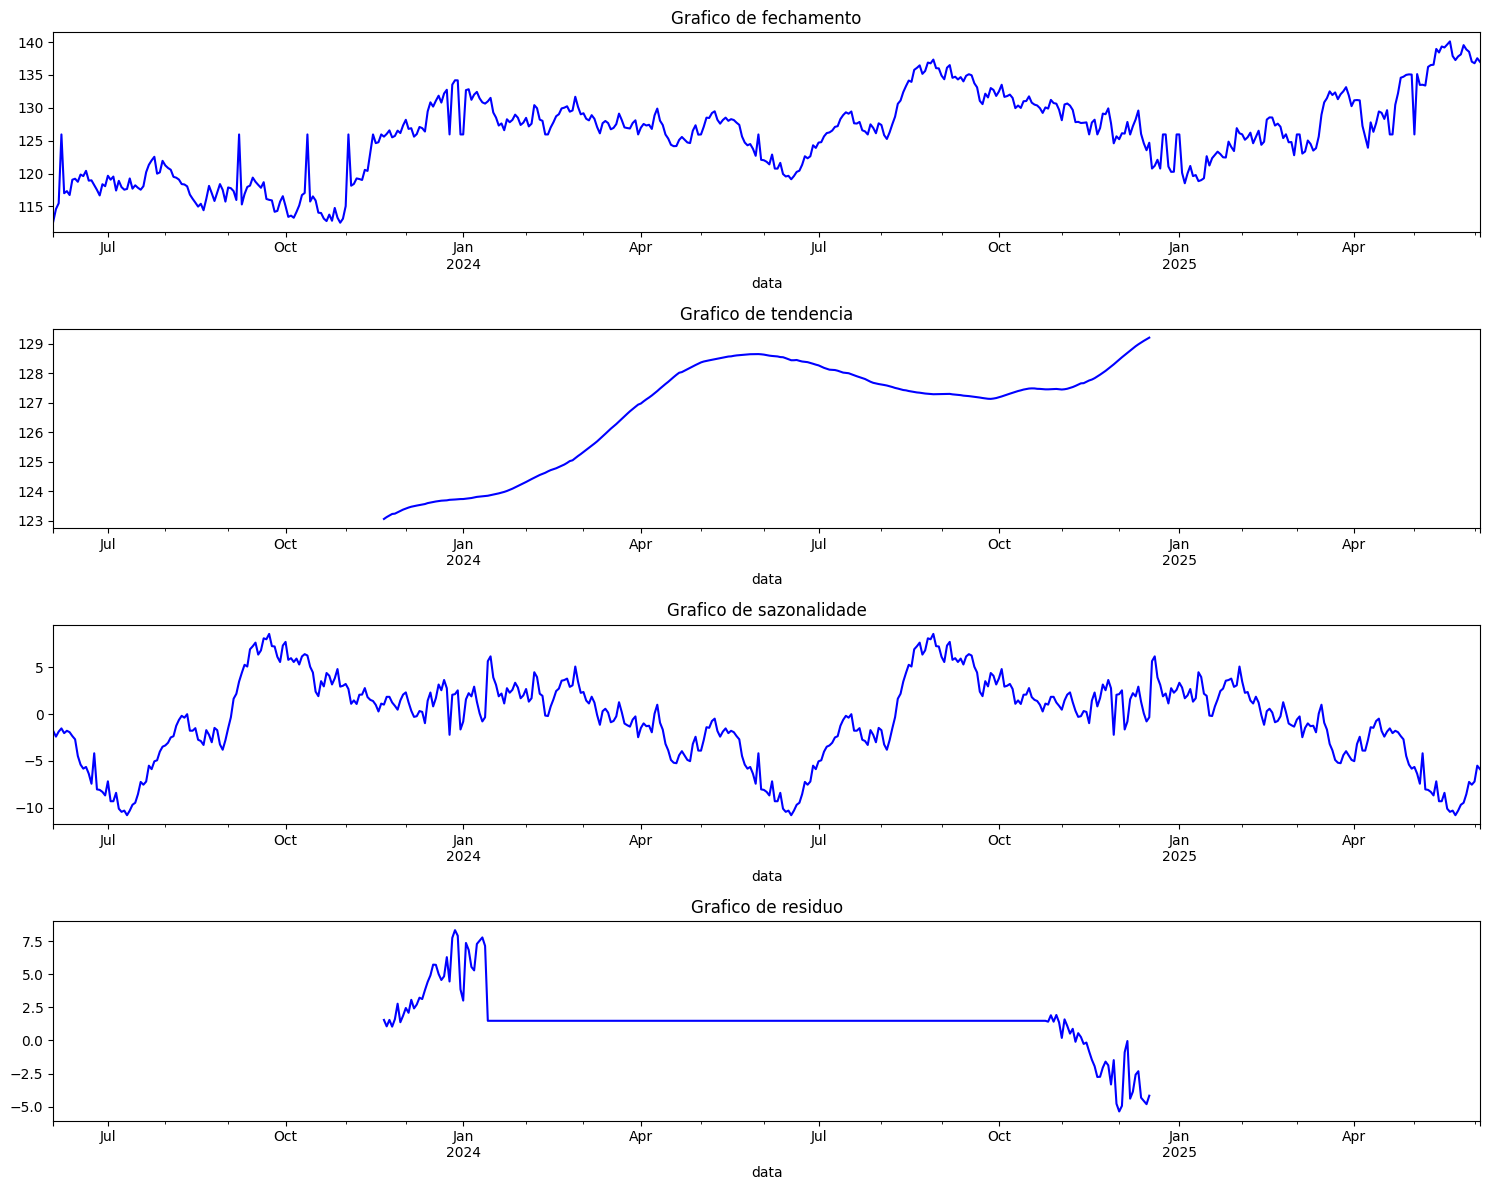

In [1689]:
resultados = seasonal_decompose(dfArima, model='additive',period = 243)

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,12))

resultados.observed.plot(ax=ax1, color = 'blue')
ax1.set_title('Grafico de fechamento')

resultados.trend.plot(ax=ax2, color = 'blue')
ax2.set_title('Grafico de tendencia')

resultados.seasonal.plot(ax=ax3, color = 'blue')
ax3.set_title('Grafico de sazonalidade')

resultados.resid.plot(ax=ax4, color = 'blue')
ax4.set_title('Grafico de residuo')

plt.tight_layout()
plt.show()

Visto que o grafico de sazonalidade apresenta picos com amplitudes constantes, iremos usar o parametro "additive".

### Transformação do serie não estacionaria em estacionaria

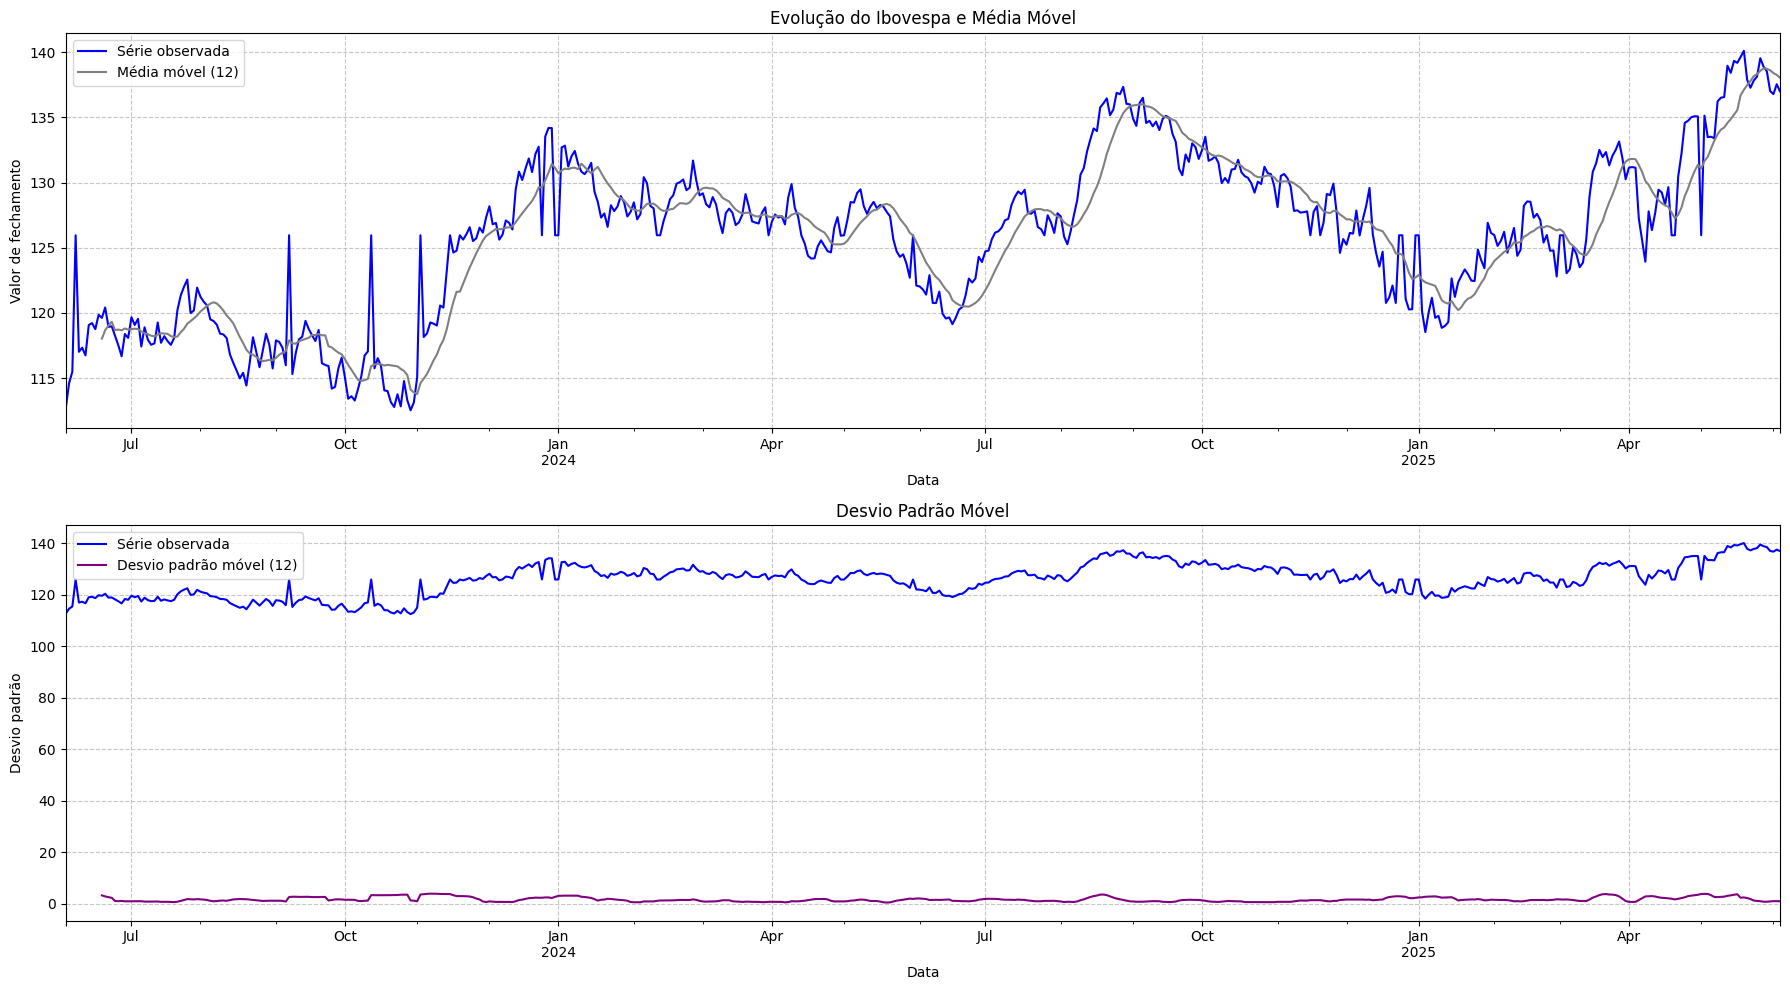

In [1690]:
ma = dfArima.rolling(12).mean()
std = dfArima.rolling(12).std()

# Cria dois subplots (2 linhas, 1 coluna)
fig, ax = plt.subplots(2, 1, figsize=(18,10))

# Plot da série e da média móvel no primeiro gráfico
dfArima.plot(ax=ax[0], color='blue', label='Série observada')
ma.plot(ax=ax[0], color='gray', label='Média móvel (12)')
ax[0].set_title('Evolução do Ibovespa e Média Móvel')
ax[0].set_xlabel('Data')
ax[0].set_ylabel('Valor de fechamento')
ax[0].grid(linestyle='--', alpha=0.7)
ax[0].legend()

# Plot do desvio padrão no segundo gráfico
dfArima.plot(ax=ax[1], color='blue', label='Série observada')
std.plot(ax=ax[1], color='purple', label='Desvio padrão móvel (12)')
ax[1].set_title('Desvio Padrão Móvel')
ax[1].set_xlabel('Data')
ax[1].set_ylabel('Desvio padrão')
ax[1].grid(linestyle='--', alpha=0.7)
ax[1].legend()

plt.tight_layout()
plt.show()

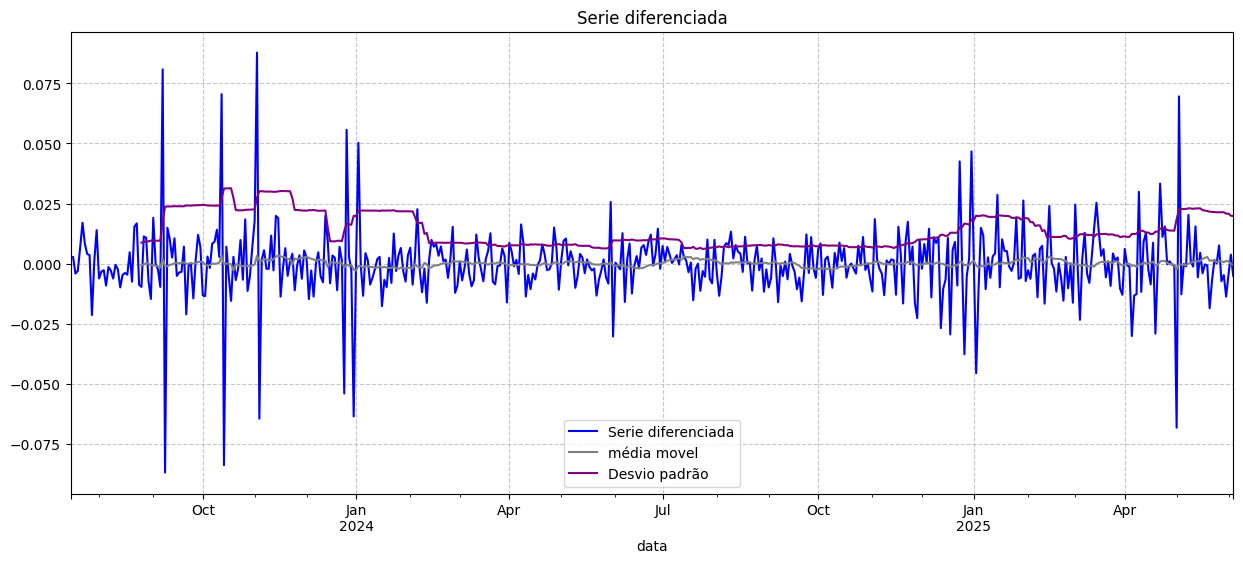

Teste ADF
Teste Estatístico: -16.97
P-Value: 9.128180865480733e-30
Valores críticos:
	1%: -3.44
	5%: -2.87
	10%: -2.57


In [1691]:
df_log = np.log(dfArima)
ma_log = df_log.rolling(30).mean()
df_s = (df_log - ma_log).dropna()

df_diff = df_s.diff(1)
ma_diff = df_diff.rolling(30).mean()
std_diff = df_diff.rolling(30).std()

f, ax = plt.subplots(figsize=(15,6))
df_diff.plot(ax=ax, label='Serie diferenciada', color = 'blue')
ma_diff.plot(ax=ax, label='média movel', color='gray')
std_diff.plot(ax=ax, label='Desvio padrão', color='purple')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.title('Serie diferenciada')
plt.show()
# plt.tight_layout()

# Correção aqui:
X_diff = df_diff.dropna().values

# Teste ADF
from statsmodels.tsa.stattools import adfuller

result_diff = adfuller(X_diff)

print("Teste ADF")
print(f"Teste Estatístico: {result_diff[0]:.2f}")
print(f"P-Value: {result_diff[1]:}")
print("Valores críticos:")

for key, value in result_diff[4].items():
    print(f"\t{key}: {value:.2f}")

In [1692]:
lag_acf = acf(df_diff.dropna(), nlags=25)
lag_pacf = pacf(df_diff.dropna(), nlags=25)

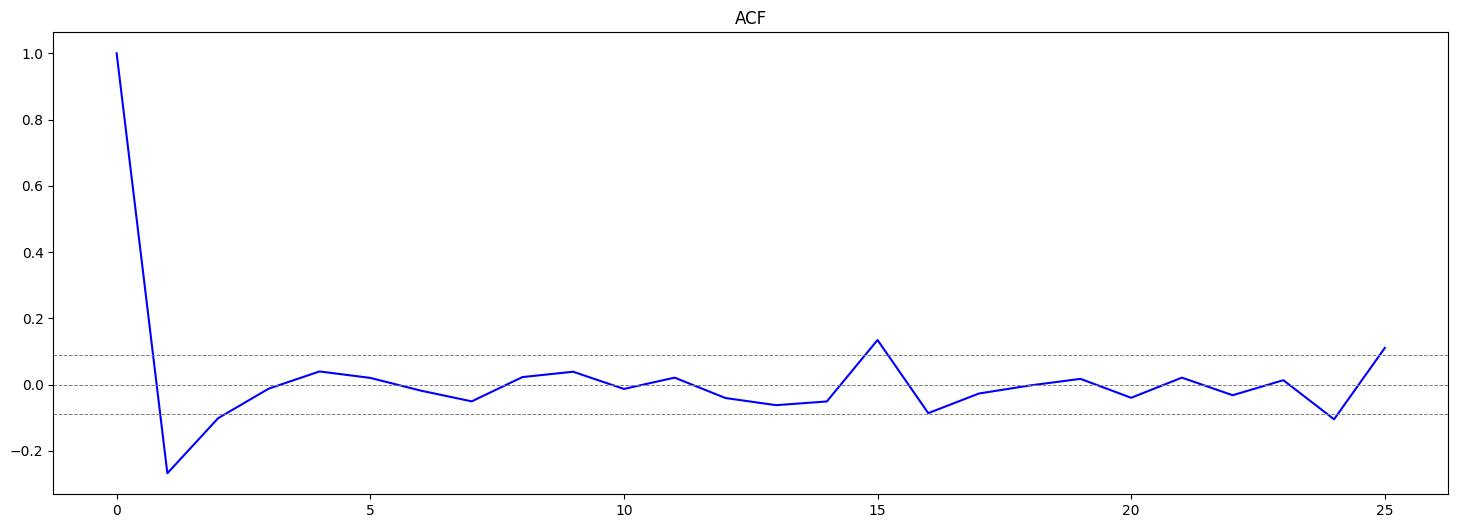

In [1693]:
plt.figure(figsize = (18,6))
plt.plot(lag_acf,color = 'Blue')

plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)

plt.title("ACF")
plt.show()

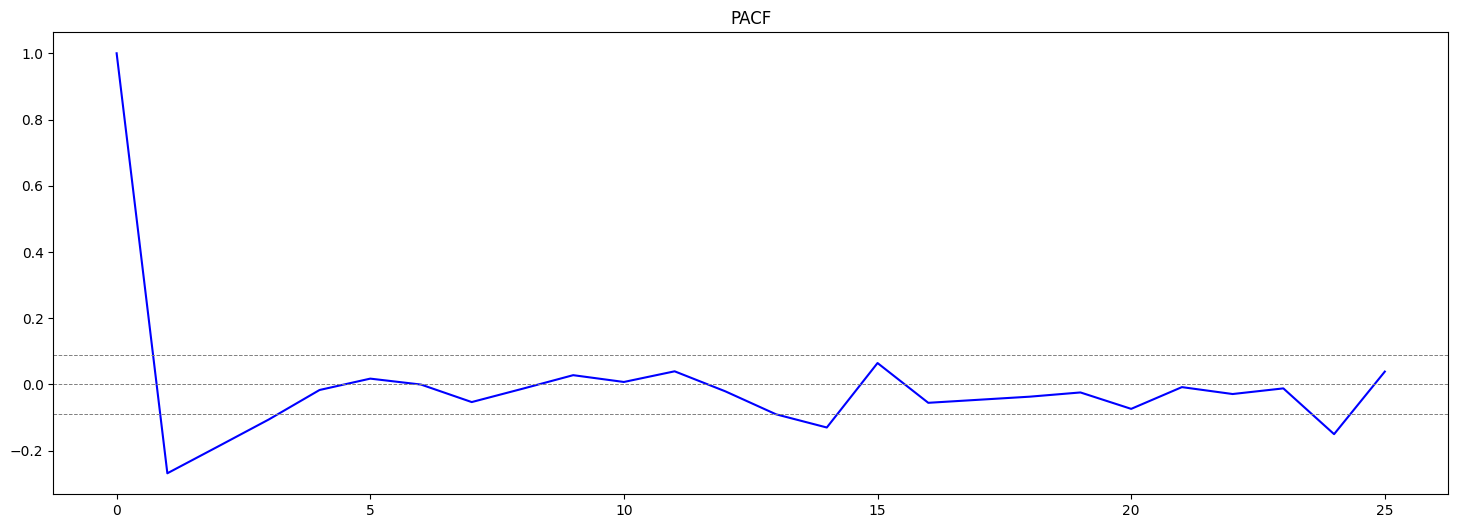

In [1694]:
plt.figure(figsize = (18,6))
plt.plot(lag_pacf,color = 'blue')


plt.axhline(y= -1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y=0, linestyle='--', color='gray',linewidth=0.7)
plt.axhline(y= 1.96/(np.sqrt((len(df_diff) -1))), linestyle='--', color='gray',linewidth=0.7)

plt.title("PACF")
plt.show()